# Lecture 4 - Backpropagation
In this lecture:

1) A review of the backpropagation process
2) Numpy implementation of a dense neural network
3) Tensorflow and Keras basics

## A brief review of backpropagation

Each neuron is defined by a bias $b$ a set of inputs $X_i$ and an associated weight $w_i$ for each input. 

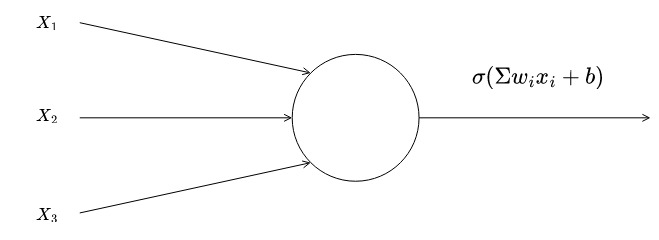

A single perceptron outputs  $ out = \sigma(z)$ where $$z = \Sigma{w_i x_i} + b$$

We call $z$ the weighted output of the neuron and $\sigma$ the activation function. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and relationships in the data. In our example we use the sigmoid function.

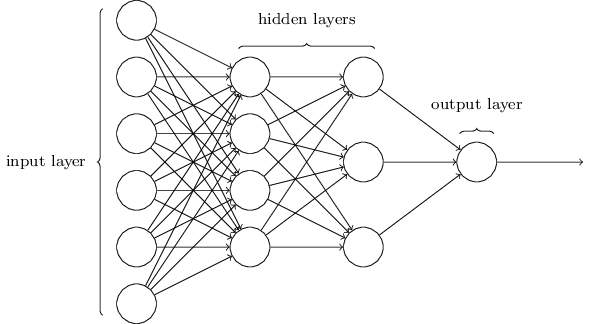

If we dispose the perceptrons in layers, we can easily parallelize these computations using matrix operations. We address the parallelized quantities by an apex specifying the layer. For example $z^l$ means all the weighted outputs of the layer $l$. 

To assess the quality of our output we need to define a cost function. The cost function depends only on the current output, and intuitively provides the feedback that we need to propagate trough the network to improve the overall performance. We call the cost function $C$ and in our example we use the quadratic cost function. 

To better understand the backpropagation algorithm we define some supporting quantities. We define the activation $a^l$ for the layer l as:  
$$a^l = \sigma(z^l)$$
We can thus define the weighted output $z^l$ for a given layer as a function of weights, biases and activations of the previous layers :
$$ z^l = w^l a^{l-1} + b^l$$
Finally we introduce the error $\delta$, which for a specific neuron $j$ in layer $l$ is defined as:
$$\delta_j^{l} = \frac{\partial C}{\partial z_j^{l}}$$
which can be interpreted as the variation on the cost function caused by the weighted output of a neuron.

Now lets take a look at the actual backpropagation algorithm, the proof for the backpropagation equations are all obtainable via the chain rule.  

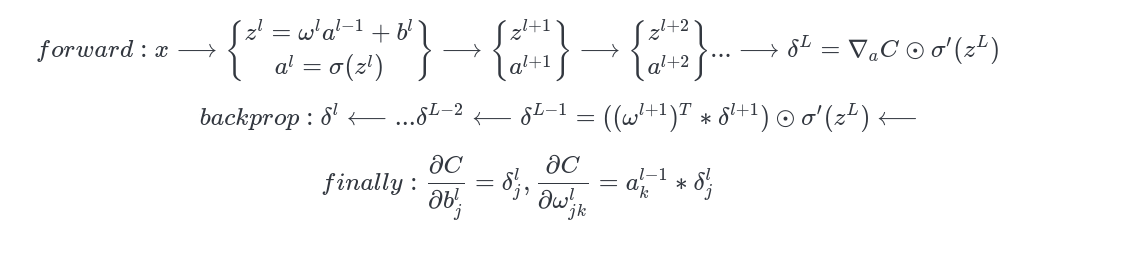

Do you remember the chain rule?

$$ \frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx} $$

#### the algorithm can be summarized in :
1) Given the input calculate all the weighted outputs and activations for all the layers
2) Compute the error for the last layer 
3) Propagate backward by calculating the errors layer by layer
4) Finally calculate the variation of the cost with respect of bias and weights 
5) Use an optimization algorithm such as gradient descent to update bias end weights 

A nice resource to better understand backpropagation and neural networks in general [Neural Networks and deep learning book](http://neuralnetworksanddeeplearning.com)

## Implementing the algorithm, using only numpy
Testing our neural network with a classic classification task on a variation of the Mnist dataset called KMnist.  

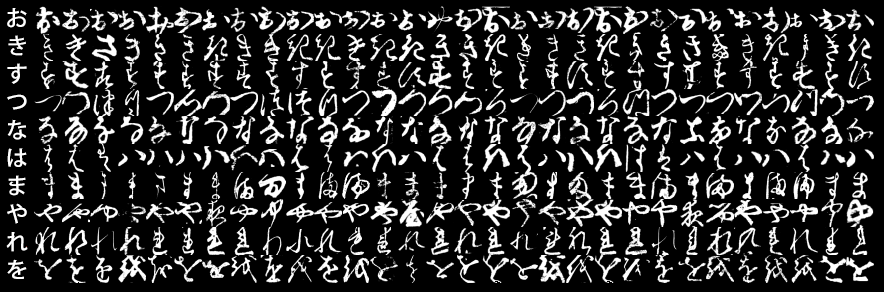

Imports

In [ ]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#import loader
import time 
import copy
# Util for pwd 
import gzip
cwd = os.getcwd()
# Data needs to be normalized 
from sklearn.preprocessing import MinMaxScaler

Accessory Functions

In [ ]:
#Given a dimension, create a random vector of biases
def set_biases(bias_matrix_dim,rnd):
    tmp = []
    for i in bias_matrix_dim:
        tmp.append(rnd.randn(i, 1))
    return tmp

def prepare_weightMatrix_dim(sizes):
    tmp = []
    for i in range(len(sizes)-1):
        tmp.append([sizes[i],sizes[i+1]])
    return tmp    

#Given a list of tuples, create random vector of matrices
def set_weights(weight_matrix_dim,rnd):
    tmp = []
    for i in weight_matrix_dim:
        tmp.append(rnd.randn(i[1], i[0]))
    return tmp


def split_data(training_data,mini_batch_size): 
    tmp = []
    for i in range(0,len(training_data),mini_batch_size):
        tmp.append(training_data[i:i+mini_batch_size])
    return tmp

#Produce the one hot encoding for class labels
def unit_vector(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [ ]:
# bias examples 
set_biases([28,28,10],np.random)[2].shape

In [ ]:
# set weights examples 
set_weights(prepare_weightMatrix_dim([784,28,28,10]),np.random)[2].shape

In [ ]:
unit_vector(2)

Writing the backpropagation algorithm

In [ ]:
def backprop(net_input, y,biases,weights,cross_entropy):
    a = [] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer

    # Two empty vectors carrying the result 
    deriv_bias = [np.zeros_like(b) for b in biases]
    deriv_weight = [np.zeros_like(w) for w in weights]

    a.append(net_input)
    # FORWARD RUN
    # Iteration trough the layers, everything computed in vector form
    for b, w in zip(biases, weights):
        #compute each intermediate value z
        z = np.dot(w, net_input)+b
        #save it for later 
        zs.append(z)
        #calculate and store each activation value 
        net_input = sigmoid(z)
        a.append(net_input)
        
    # backward run trough the network 
    
    # calculate the first delta 
    if(cross_entropy == True):
        delta = crosscost_derivarive(a[-1], y,zs[-1]) 
    else:
        delta = quadcost_derivative(a[-1], y,zs[-1]) 

    deriv_bias[-1] = delta
    deriv_weight[-1] = np.dot(delta, a[-2].transpose())
    
    #BACKWARD RUN 
    for l in range(-2, -len(sizes),-1):
        z = zs[l]
        sigma_prime = sigmoid_deriv(z)
        # calculate current delta 
        # Hadamard product *
        delta = np.dot(weights[l+1].transpose(), delta) * sigma_prime
        # calculate each value for bias and weight, as in (BP3/4)
        deriv_bias[l] = delta
        deriv_weight[l] = np.dot(delta, a[l-1].transpose())
    #return the two vectors 
    return (deriv_bias, deriv_weight)

def quadcost_derivative(output_activations, y,z):
        return ((output_activations-y) * sigmoid_deriv(z))
    
def crosscost_derivarive(output_activations, y,z):
        #Simply remove the sigmoid term
        return (output_activations-y) 

def evaluation(test_data,biases,weights):
        tmp = []
        results = []
        # we get the output for every test input
        for x,y in test_data:
            results.append((net_output(x,biases,weights),y))
        for i in results:
            # Argmax for finding the most likely result 
            tmp.append((np.argmax(i[0]),i[1]))
        correct_classifications = 0
        for (x,y) in tmp:
            if(int(x)==int(y)):
                correct_classifications = correct_classifications + 1
        return correct_classifications
    
def net_output(net_input,biases,weights):
    #Forward pass in the network 
    # get current output given input (evaluation purposes)    
    for i in range(len(weights)):
        current_z = np.dot(weights[i],net_input) + biases[i]
        net_input = sigmoid(current_z)
    return net_input

def sigmoid(z):
    try:
        return 1.0/(1.0+np.exp(-z))
    except:
        # Overflow check 
        print(z)
    
def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))


Now we define the main parameters of our network

In [ ]:
#Set network architecture
sizes = [784,28,28,10]
#Set if unsaturated weights
epochs = [10]
mini_batches_len = [64]
eta = [0.6]
cross_entropy = [True,False]
L2_regularization = [True,False]

Loading the data

In [ ]:
def load_data():
    #load data 
    test_imgs = np.load("./kmnist-test-imgs.npz")['arr_0']
    test_labels = np.load("./kmnist-test-labels.npz")['arr_0']
    train_imgs = np.load("./kmnist-train-imgs.npz")['arr_0']
    train_labels = np.load("./kmnist-train-labels.npz")['arr_0']
    
    #cast 
    test_imgs = test_imgs.astype("float32")
    train_imgs = train_imgs.astype("float32")
    test_labels = test_labels.astype("int64")
    train_labels = train_labels.astype("int64")

    # Reshape so that the input is a single array of dimension 784 
    #(rather than 28x28)
    test_imgs = np.reshape(test_imgs,[10000,784])
    train_imgs = np.reshape(train_imgs,[60000,784])

    # Data is raw, normalization is necessary to avoid overflow with the sigmoid 
    scaler = MinMaxScaler(feature_range=(0,1))
    test_imgs = scaler.fit_transform(test_imgs)
    train_imgs = scaler.fit_transform(train_imgs)

    # Transform the data in a zip iterable object 
    training_inputs = [np.reshape(x,[784,1]) for x in train_imgs]
    training_results = [unit_vector(y) for y in train_labels]
    training_data = zip(training_inputs, training_results)
    test_inputs = [np.reshape(x, [784,1]) for x in test_imgs]
    test_data = zip(test_inputs, test_labels)

    return (list(training_data), list(test_data))

In [ ]:
training_data, test_data = load_data()

In [ ]:
training_data[0][0].shape

In [ ]:
training_data[0][1]

We define the main training loop

In [ ]:
def train(training_data, epochs, mini_batch_size, eta,test_data,weights,biases,rnd,plot=True,L2=True,cross_entropy=False):
    # Start time, timestamps for tuning purposes 
    start = time.time()
    train_evaluation = []
    timestamps =  []
    #Setup of logs for visualization purposes 
    biases_log = []
    weights_log = []

    n_test = len(test_data)
    # cycle trough the requested number of epochs 
    for i in range(epochs):
        # Shuffle the training data, so to achieve random batches
        rnd.shuffle(training_data)
        # split the data in batches
        mini_batches = split_data(training_data, mini_batch_size)
        print("mini batches number : ", len(mini_batches))

        # SGD
        # Update paramenters for each mini batch
        for mini_batch in mini_batches:

                # Prepare the lists for the partial derivatives of weights and biases
                partial_deriv_biases = [np.zeros_like(b) for b in biases]
                partial_deriv_weights = [np.zeros_like(w) for w in weights]

                # for each training example run trough the network
                for x, y in mini_batch:
                    # we obtain from the network the two vectors 
                    # containing the partial derivatives with respect to weight and bias
                    deriv_bias, deriv_weight = backprop(x, y,biases,weights,cross_entropy)
                    #sum the values
                    for l in range(len(partial_deriv_biases)):
                        partial_deriv_biases[l] = partial_deriv_biases[l] + deriv_bias[l]
                    for l in range(len(partial_deriv_weights)):
                        partial_deriv_weights[l] = partial_deriv_weights[l] + deriv_weight[l]

                # finally compute the updated values of weights and biases         
                # Optional L2 regularization 
                if(L2==True):
                    # L2 reg parameter
                    lambda_ = 4
                    for l in range(len(weights)):
                        weights[l] = ((1-(lambda_/len(training_data))) * weights[l]) - (eta/len(mini_batch))*partial_deriv_weights[l]
                else:
                    for l in range(len(weights)):
                        weights[l] = weights[l] - (eta/len(mini_batch))*partial_deriv_weights[l]

                for l in range(len(biases)):
                        biases[l] = biases[l] - (eta/len(mini_batch))*partial_deriv_biases[l]


        # time evaluation
        timestamps.append(time.time() - start)

        #Get current net performance 
        v = evaluation(test_data,biases,weights)
        print("{0} --> correct classifications: ({1} / {2}) ".format(
            i, v, n_test))
        # update the train evaluation list 
        train_evaluation.append(v)


        # Following commands for plotting 
        if(plot==True):
            level = 1 # choose which level of the network to plot 
            biases_log.append(biases[level])
            weights_log.append(weights[level])

    return train_evaluation, timestamps, biases_log, weights_log


Training the network

In [ ]:
num_layers = len(sizes)
# Prepare biases for each level except the first 
bias_matrix_dim = sizes[1:]
# Prepare weights 
weight_matrix_dim = prepare_weightMatrix_dim(sizes)

print("bias matrix dim", bias_matrix_dim)
print("weight matrix dim",weight_matrix_dim)

rnd = np.random.RandomState(121)

biases = set_biases(bias_matrix_dim,copy.deepcopy(rnd))
weights = set_weights(weight_matrix_dim,copy.deepcopy(rnd))

train_evaluation = []
timestamps = []
train_evaluation2 = []
timestamps2 = []

# Load the data, as zip iterables 
training_data, test_data = load_data()

# Set error so to be reactive to overflow 
np.seterr(all='print')

# Call the two train methods 
train_evaluation,timestamps, biases_log, weights_log = train(copy.deepcopy(training_data), epochs[0], mini_batches_len[0], eta[0],
                                    copy.deepcopy(test_data),copy.deepcopy(weights),copy.deepcopy(biases),copy.deepcopy(rnd),
                                    L2=L2_regularization[0],
                                    cross_entropy=cross_entropy[0])


Let's visualize the changing of weights 
throughout the epochs!

In [ ]:
%matplotlib inline
num_images = len(weights_log)
image_data = weights_log

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(image_data[0], animated=True)

def update(frame):
    im.set_array(image_data[frame])
    return im,

ani = FuncAnimation(fig, update, frames=range(num_images), repeat=True)
plt.close()
# Display the animation
HTML(ani.to_jshtml())

And the changing of biases 

In [ ]:
%matplotlib inline
num_images = len(biases_log)
image_data = biases_log

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(image_data[0], animated=True)

def update(frame):
    im.set_array(image_data[frame])
    return im,

ani = FuncAnimation(fig, update, frames=range(num_images), repeat=True)
plt.close()
# Display the animation
HTML(ani.to_jshtml())

In [ ]:
# Plot a train evaluation
fig2, ax = plt.subplots()
ax.plot(timestamps,train_evaluation,color="red",label="1- batchLen: {0}, eta: {1}, epochs: {2}".format(mini_batches_len[0],eta[0],epochs[0]))
ax.set(xlabel='time (s)', ylabel='score',
       title='train evaluation')
ax.grid()
ax.legend(shadow=True, fontsize="large")

plt.show()

# Tf/Keras
A powerful framework for neural network 

TensorFlow is an open-source platform designed for high performance numerical computation, developed by the google brain team. It facilitates the creation of large-scale neural networks with numerous layers, thanks to its automatic differentiation capability and strong support for deep learning models.

At the heart of TensorFlow's functionality is the ability to execute intensive mathematical operations on a large scale and with high efficiency. This is particularly beneficial in training complex neural networks, where such operations are widespread. TensorFlow excels in scalability and flexibility, allowing it to run on multiple CPUs and GPUs, as well as on mobile devices.

Keras, integrated into TensorFlow as tf.keras, provides a more accessible interface to the TensorFlow library by abstracting away much of the complexity. Keras is user-friendly and modular, making it simple for beginners to build and experiment with neural networks. Its API is designed with human beings in mind, not just machines, offering a balance between ease of use and flexibility.

In practive, __Keras provides a user-friendly framework for building neural networks, while TensorFlow offers granular control for specialized tasks within the keras Keras implementation__

### Keras Sequential 
The Keras Sequential API is a straightforward yet powerful tool for creating neural network models in Python. It allows developers to construct models layer-by-layer in a step-by-step fashion. The Sequential model is a linear stack of layers, making it ideal for building simple, yet deep, neural networks without the complexity of graph-like architectures.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.datasets import mnist
from keras.utils import to_categorical

In [ ]:
model = Sequential([
    Flatten(input_shape=(28 *28,)),
    Dense(784, activation = "swish"),
    Dropout(0.3),
    Dense(100, activation = "swish"),
    Dense(10, activation = "softmax")
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
# How is L2 regularization added to the network?

In [ ]:
# Load and preprocess the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=128)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

### How to choose an activation function?

The choice is often quite straight forward:
 - If I have a classification problem for the last layer the standard is the softmax, returning a probability distribution of the outcomes (the sum of all the probability for all classes is 1)
 - In the case of a binary classification problem Sigmoid is the most common function, similarly to softmax
 - for deep layers, ReLu is commonly the standard, mainly because of it's effectiveness in avoiding the vanishing gradient problem. Other common issues of ReLu (dying neurons) are solved via the use of LeakyRelu, Swish-
 - tanh mean is 0, which can help stabilize the network and avoid axploding gradient, such as in recurrent neural networks. 
- The Exponential Linear Unit (ELU) activation function, on the other hand, has a small slope for negative values, which helps reduce the vanishing gradient problem, allowing the model to learn even when the neurons are in the negative saturation region. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: np.tanh(x)
relu = lambda x: np.maximum(0, x)
leaky_relu = lambda x, alpha=0.01: np.where(x > 0, x, x * alpha)
swish = lambda x: x / (1 + np.exp(-x))
elu = lambda x, alpha=1.0: np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Range of values
x = np.linspace(-3, 3, 200)

# Plotting
plt.figure(figsize=(8, 6))

for i, (func, title) in enumerate(zip([sigmoid, tanh, relu, leaky_relu, swish, elu], 
                                      ["Sigmoid", "Tanh", "ReLU", "Leaky ReLU", "Swish", "ELU"])):
    plt.subplot(2, 3, i+1)
    plt.plot(x, func(x))
    plt.title(title)
    plt.grid()
    plt.ylim([-1.5, 3])

plt.tight_layout()
plt.show()

### How to choose an optimizer?

We will focus just on the default optimizers provided by Keras: 
 - SGD, simplest and most efficient optimizer. In Keras also support momentum based optimization. Good for large datasets and simple optimization problems. 
 - Adagrad - Adjusts the learning rate for each parameter based on the historical sum of squares of the gradients, which means it gives smaller updates for frequently occurring features, can be good for sparse data. 
 - RMSProp, utilizes the moving average of squared gradients to normalize the gradient, this means it adapts the learning rate for each weight. Can be seen as an updated version of Adagrad. 
 - Adam (Adaptive Momentum Estimation), Combines the benefits of AdaGrad and RMSprop, adjusting the learning rate for each weight based on the first (mean) and second (uncentered variance) moments of the gradients. Very popular due to its robust performance across a wide variety of models and problems. It’s often the first choice in many deep learning applications.

Usually, Adam is a good starting choice for most deep learning applications.

### How to choose a loss?

The loss function is a one of the most problem-specific part of a neural network. It is often the case that a custom loss function is needed. Generally speaking, if the problem is a regression (continous output) a MAE or MSE is commonly used. 

If the problem is a classification (binary or multi class) a variation of categorical cross-entropy is often utilizied. 

In conclusion, for what concerns losses, optimizers and activations consider that some practical results are often necessary other than the more theoretical aspects. 

### Keras Functional API
The Keras Functional API is a way to create models that are more flexible than the Sequential API, which allows you to create models that cannot be defined with a linear stack of layers. With the Functional API, you can manipulate the inputs and outputs, and build models that have multiple inputs and outputs, shared layers, and even non-sequential data flows like residual connections.

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Add, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.utils import to_categorical

# Load and preprocess the data (same as above)

# Build the model using the Functional API
inputs = Input(shape=(28 * 28,))
x = Flatten()(inputs)
x = Dense(784, activation="relu")(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=128)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')
#x2 = Dense(128, activation='relu')(x)
#x = Add()([x1,x2])
#shared = Dense(784, activation='relu')
#x = shared(x)
#x = shared(x)
#x = BatchNormalization()(x)

Can you guess what Dropout and BatchNormalization do?

In [ ]:
model.summary()

Other model examples utilizing the Keras Functional API, multiple inputs

In [ ]:
# Just a model example, not meant to be executed
from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model

# First input: Categorical data that we will embed
categorical_input = Input(shape=(10,), dtype='int32', name='categorical_input')
x = Embedding(output_dim=512, input_dim=10000, input_length=10)(categorical_input)
lstm_out = LSTM(32)(x)

# Second input: Numerical data
numerical_input = Input(shape=(5,), name='numerical_input')
n = Dense(32, activation='relu')(numerical_input)

# Merge all available features into a single large vector via concatenation
x = concatenate([lstm_out, n])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

model = Model(inputs=[categorical_input, numerical_input], outputs=[main_output])

### Model API with custom dense layer and Custom gradient loop

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Input, Dense, Flatten, BatchNormalization
from keras.datasets import mnist
from keras.utils import to_categorical

# Custom Layer Example
class CustomDense(Layer):
    def __init__(self, units, activation=None):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

# Load and preprocess the data (same as above)

# Build the model with a custom layer
inputs = Input(shape=(28 * 28,))
x = Flatten()(inputs)
x = CustomDense(512, activation='relu')(x)
x = CustomDense(128, activation='relu')(x)
outputs = CustomDense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

A Simple Gradient Tape Loop

In [ ]:
# Custom training loop
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Prepare the training dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

for epoch in range(5):
    print(epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)


A more advanced loop

In [ ]:
# Custom training loop
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

# Prepare the training dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = val_dataset.batch(batch_size)

# Training and validation loop
epochs = 5
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Reset the metrics at the start of the next epoch
    train_acc_metric.reset_states()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print("Training loss (for one batch) at step %d: %.4f" % (step, loss_value.numpy()))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_accuracy = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_accuracy),))

    # Reset the validation metrics
    val_acc_metric.reset_states()

    # Perform validation at the end of each epoch
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_accuracy = val_acc_metric.result()
    print("Validation acc: %.4f" % (float(val_accuracy),))

Some notes on Dropout and Batch Normalization

__Batch normalization__ is important in neural architectures because it helps in stabilizing and accelerating the training process by normalizing the inputs of each layer. It does this by adjusting and scaling the activations, which allows each layer of a network to learn more independently of other layers. 

This normalization helps to combat the internal covariate shift problem, where the distribution of input data keeps changing during training, making it difficult for the network to converge. Additionally, batch normalization often allows for the use of higher learning rates and reduces the sensitivity to weight initialization, both of which can lead to faster convergence. It can also act as a form of regularization, potentially reducing the need for other regularization techniques like dropout.

__Dropout__ on the other hand is a regularization technique used in neural networks to prevent overfitting. It works by randomly dropping a subset of neurons during each training iteration, which helps to break up co-adaptations where neurons rely too heavily on the presence of particular other neurons. This encourages the network to develop more robust features that are useful in conjunction with many different random subsets of the other neurons. Dropout can significantly improve the performance of neural networks on test data by promoting the creation of a more generalized model.

We can now start exploring the default library of keras examples, full of great starting point for neural projects. 
https://keras.io/examples/

See you next time!